In [1]:
cd '~/cloudFinder/'

/home/antoine/cloudFinder


In [20]:
import jupyterlab_dash
import dash
import dash_core_components as dcc
import dash_html_components as html

from dash.dependencies import Input, Output
import feather as ft 
import pandas as pd
import base64
import dash_table
from io import BytesIO
from skimage import measure


import plotly.graph_objects as go
import plotly.offline as po

from src.image.utils import load_image
from src.image.transform import resize_image
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
viewer = jupyterlab_dash.AppViewer(port=9998)

======================================================================================================

In [21]:
MODEL_PATH = 'data/process/sky_segmentation/'

======================================================================================================

In [22]:
df_score = ft.read_dataframe(MODEL_PATH + '/score_per_image.ft')
df_score.head()

,img_name,prediction_label,metric,score
0,labelme_aacpgupgzvdjapw.jpg,is_sky_PREDICTED,accuracy,0.866917
1,labelme_aacpgupgzvdjapw.jpg,is_sky_PREDICTED,precision,0.741146
2,labelme_aacpgupgzvdjapw.jpg,is_sky_PREDICTED,recall,0.589976
3,labelme_aacpgupgzvdjapw.jpg,is_sky_PREDICTED_COR,accuracy,0.881729
4,labelme_aacpgupgzvdjapw.jpg,is_sky_PREDICTED_COR,precision,0.874424


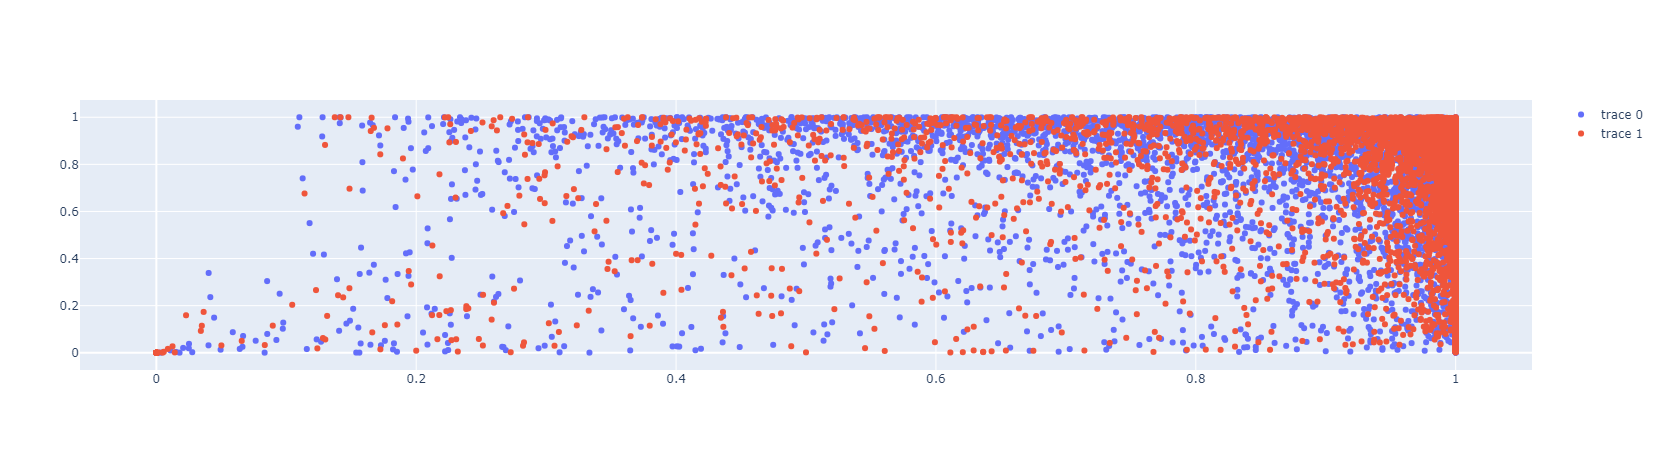

In [26]:
data = []

tmp = df_score.groupby(['prediction_label', 'img_name', 'metric']).mean().loc['is_sky_PREDICTED', 'score'].unstack(level=1).reset_index()
data.append(go.Scatter(x=tmp['precision'], y=tmp['recall'], mode='markers'))

tmp = df_score.groupby(['prediction_label', 'img_name', 'metric']).mean().loc['is_sky_PREDICTED_COR', 'score'].unstack(level=1).reset_index()
data.append(go.Scatter(x=tmp['precision'], y=tmp['recall'], mode='markers'))

po.iplot(go.Figure(data))

In [6]:
df_cv = ft.read_dataframe(MODEL_PATH + '/cv.ft')
df_cv['is_sky'] = df_cv['is_sky'].astype(int)
df_cv.head()

,img_name,is_sky_PREDICTED,fold,is_sky,is_sky_PREDICTED_COR
0,labelme_aacpgupgzvdjapw.jpg,0,3,0,0
1,labelme_aacpgupgzvdjapw.jpg,0,3,0,0
2,labelme_aacpgupgzvdjapw.jpg,1,3,0,0
3,labelme_aacpgupgzvdjapw.jpg,1,3,0,0
4,labelme_aacpgupgzvdjapw.jpg,1,3,0,0


In [7]:
df_meta = ft.read_dataframe(MODEL_PATH + '/traindataset_meta.ft')
df_meta.head()

,size_h,size_l,sky_coverage,is_used,img_name
0,100,133,0.216015,True,labelme_aacpgupgzvdjapw.jpg
1,100,133,0.103534,True,labelme_aajuldidvlcyzhv.jpg
2,0,0,0.002105,False,labelme_aajvoauwthyaehf.jpg
3,100,133,0.337744,True,labelme_aalbzqrimafwbiv.jpg
4,0,0,0.022632,False,labelme_aatpnkdmtvmagyh.jpg


In [8]:
all_img = set(df_cv['img_name'])
all_metric = set(['accuracy', 'recall', 'precision'])

In [9]:
external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
    [
        html.Div([html.H1(children="Sky segmentation"),], className="row"),
        html.Div(
            [
                html.Div(
                    [
                        html.H6(children="Metric"),
                        dcc.Dropdown(
                            options=[{"label": i, "value": i} for i in all_metric],
                            value="accuracy",
                            multi=False,
                            id="metric",
                        ),
                        html.H6(children="Image score"),
                        dash_table.DataTable(
                            id="score_table",
                            columns=[
                                {"name": i, "id": i}
                                for i in ["Image", "Score", "Corrected Score"]
                            ],
                            sort_action="native",
                            page_size=10,
                            style_table={"maxHeight": "50", "overflowY": "scroll"},
                        ),
                    ],
                    className="four columns",
                ),
                html.Div(
                    [html.H6(children="Score"), dcc.Graph(id="box_plot"),],
                    className="eight columns",
                ),
            ],
            className="row",
        ),
        html.Div(
            [
                html.Div(
                    [
                        html.H6(children="image name"),
                        dcc.Dropdown(
                            options=[{"label": i, "value": i} for i in all_img],
                            value="labelme_aacpgupgzvdjapw.jpg",
                            multi=False,
                            id="img_name",
                        ),
                        html.H6(children="With correction"),
                        dcc.RadioItems(
                            id="corr",
                            options=[
                                {"label": i, "value": i} for i in ["True", "False"]
                            ],
                            value="False",
                            labelStyle={"display": "inline-block"},
                        ),
                        html.H6(children="confusion matrix"),
                        dcc.Markdown(
                            children="""
                                            |          | pos      | neg      |
                                            |----------|----------|----------|
                                            | Pred Pos | 0   | 0  | 
                                            | Pred Neg | 0   | 0  | 
                                        """,
                            id="confusion_matrix",
                        ),
                    ],
                    className="four columns",
                ),
                html.Div(
                    [html.H6(children="Image"), html.Img(src="", id="img_plot"),],
                    className="eight columns",
                ),
            ],
            className="row",
        ),
    ],
    className="ten columns offset-by-one",
)

In [10]:
@app.callback(
    Output("box_plot", "figure"), [Input("metric", "value")]
)
def update_plot(metric):
    tmp = df_score.groupby(['metric', 'img_name', 'prediction_label']).mean().loc[metric, 'score'].unstack(level=1).reset_index()
    data = []
    data.append(go.Box(y=tmp["is_sky_PREDICTED"], name= "without_cor"))
    data.append(go.Box(y=tmp["is_sky_PREDICTED_COR"], name="with_cor"))
    return {"data": data}

In [11]:
@app.callback(
    Output("confusion_matrix", "children"),
    [Input("img_name", "value"), Input("corr", "value")],
)
def update_confusion_matrix(img_name, with_correction):

    if with_correction == "True":
        pred_label = "is_sky_PREDICTED_COR"
    else:
        pred_label = "is_sky_PREDICTED"

    tmp = df_cv[df_cv["img_name"] == img_name].copy()

    tn, fp, fn, tp = confusion_matrix(tmp["is_sky"], tmp[pred_label]).ravel()

    txt = """
        |          | pos      | neg      |
        |----------|----------|----------|
        | Pred Pos | {}   | {}  | 
        | Pred Neg | {}   | {}    |
        """.format(
        tp, fp, fn, tn
    )
    return txt

In [12]:
@app.callback(Output('score_table', 'data'), [Input('metric', 'value')])
def update_table(metric):
    tmp = df_score.groupby(['metric', 'img_name', 'prediction_label']).mean().loc[metric, 'score'].unstack(level=1).reset_index()
    tmp.columns = ["Image", "Score", "Corrected Score"]
    return tmp.to_dict("rows")


In [13]:
@app.callback(
    Output("img_plot", "src"), [Input("img_name", "value"), Input("corr", "value")]
)
def update_image(img_name, with_correction):

    if with_correction == "True":
        pred_label = "is_sky_PREDICTED_COR"
    else:
        pred_label = "is_sky_PREDICTED"

    size_h, size_l = df_meta[df_meta.img_name == img_name][["size_h", "size_l"]].iloc[0]

    df_cv_image = df_cv[df_cv.img_name == img_name].copy()

    sky = df_cv_image["is_sky"].values.reshape((size_h, size_l))
    sky_contours = measure.find_contours(sky, 0)
    
    sky_predicted = df_cv_image[pred_label].values.reshape((size_h, size_l))
    sky_predicted_contours = measure.find_contours(sky_predicted, 0)

    img = load_image("data/img/sky_segmentation/", img_name)
    img_resized = resize_image(img, 100)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_resized)
    for n, c in enumerate(sky_contours):
        ax.plot(c[:, 1], c[:, 0], linewidth=3, color="r")
    for n, c in enumerate(sky_predicted_contours):
        ax.plot(c[:, 1], c[:, 0], linewidth=3, color="y")
    figfile = BytesIO()
    plt.savefig(figfile, format="png")
    figdata_png = base64.b64encode(figfile.getvalue()).decode()

    src = "data:image/png;base64,{}".format(figdata_png)

    return src

In [14]:
viewer.stderr_queue.write('Running on'.encode('utf-8'))
viewer.show(app)

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/antoine/cloudFinder_env/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/antoine/cloudFinder_env/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/antoine/cloudFinder_env/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/antoine/cloudFinder_env/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/antoine/cloudFinder_env/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/antoine/cloudFinder_env/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/home/ant

In [38]:
viewer.terminate()